#### Differential photometry
Through this Jupyter notebook, we will see how to use the aperture photometry of our target and reference star(s) to obtain the differential photometry of our target

What's the difference between aperture photometry and differential photometry?
et's first analyze the output of our AperturePhotometry class

First, we load one of the science frames to highlight the selected stars, the parameters of the sky annulus, and the aperture of choice, following the results obtained during the previous lectures

In [66]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from astropy.io import fits 
import pickle 
import matplotlib.colors as colors

In [67]:
science_list=np.genfromtxt("./science/science.list", dtype='str')
science_frame_name = './correct/' + science_list[0][:-5] + '_corr.p'
science_corrected =    pickle.load(open(science_frame_name, 'rb'))

In [69]:
def make_annulus_around_star(x_pos, y_pos,  inner_radius, outer_radius, label='', color='y'):
    from matplotlib.patches import Circle

    n, radii = 50, [inner_radius, outer_radius]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=0.75, label=label)



def make_circle_around_star(x_pos, y_pos, radius, thickness=0.5, label='', color='w', alpha=1.):
    from matplotlib.patches import Circle

    n, radii = 50, [radius, radius+thickness]
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    ax.fill(np.ravel(xs)+x_pos, np.ravel(ys)+y_pos, edgecolor=None, facecolor=color, alpha=alpha, label=label)

vmin:  529.2    vmax: 103953.7


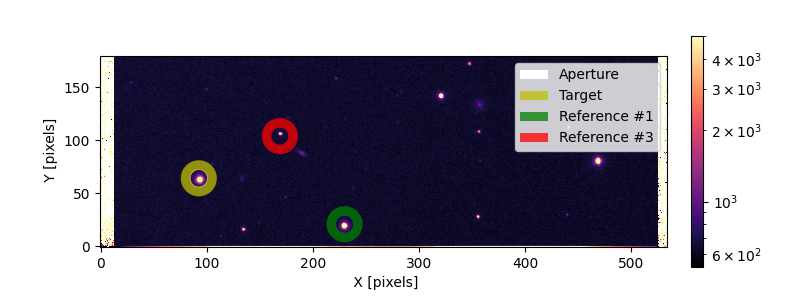

In [71]:
x_target = 92.61
y_target = 64.27

x_reference_01 = 230
y_reference_01 = 21

#x_reference_02 = 468
#y_reference_02 = 82

x_reference_02 = 169
y_reference_02 = 104

aperture = 8 # 6 10
inner_radius = 8
outer_radius = 17

vmin = np.amin(science_corrected[:,100:400])
vmax = np.amax(science_corrected[:,100:400])
print('vmin:  {0:.1f}    vmax: {1:.1f}'.format(vmin, vmax))
vmax = 5000

fig, ax = plt.subplots(1, figsize=(8,3))
im1 = plt.imshow(science_corrected, cmap=plt.colormaps['magma'], norm=colors.LogNorm(vmin=vmin, vmax=vmax), origin='lower')
plt.colorbar(im1,ax=ax, fraction=0.046, pad=0.04)

make_circle_around_star(x_target, y_target, aperture, label='Aperture')

make_annulus_around_star(x_target, y_target, inner_radius, outer_radius, label='Target')
make_annulus_around_star(x_reference_01, y_reference_01, inner_radius, outer_radius, label='Reference #1', color='g')
make_annulus_around_star(x_reference_02, y_reference_02, inner_radius, outer_radius, label='Reference #3', color='r')

plt.xlabel(' X [pixels]')
plt.ylabel(' Y [pixels]')
ax.legend()
plt.show()

#### Importing the AperturePhotometry class

In [72]:
from classing import AperturePhotometry

from time import time
t0 = time()


aperture = 8 # 6 10
inner_radius = 8
outer_radius = 17

target_ap08 = AperturePhotometry()
target_ap08.provide_aperture_parameters(inner_radius, outer_radius, aperture, x_target, y_target)
target_ap08.aperture_photometry()

reference01_ap08 = AperturePhotometry()
reference01_ap08.provide_aperture_parameters(inner_radius, outer_radius, aperture, x_reference_01, y_reference_01)
reference01_ap08.aperture_photometry()

reference02_ap08 = AperturePhotometry()
reference02_ap08.provide_aperture_parameters(inner_radius, outer_radius, aperture, x_reference_02, y_reference_02)
reference02_ap08.aperture_photometry()

t1 = time()
print('elapsed_time=', t1-t0)

/Users/alina.zakareeva/Desktop/Lab 2/TASTE_analysis/classing.py:256: RuntimeWarning: divide by zero encountered in divide
  science_corrected = science_debiased / self.median_normalised_flat
/Users/alina.zakareeva/Desktop/Lab 2/TASTE_analysis/classing.py:256: RuntimeWarning: invalid value encountered in divide
  science_corrected = science_debiased / self.median_normalised_flat
/Users/alina.zakareeva/Desktop/Lab 2/TASTE_analysis/classing.py:154: RuntimeWarning: invalid value encountered in multiply
  total_flux = np.nansum(science_data * sel)
/Users/alina.zakareeva/Desktop/Lab 2/TASTE_analysis/classing.py:155: RuntimeWarning: invalid value encountered in multiply
  flux_x = np.nansum(science_data * sel, axis=0)
/Users/alina.zakareeva/Desktop/Lab 2/TASTE_analysis/classing.py:156: RuntimeWarning: invalid value encountered in multiply
  flux_y = np.nansum(science_data * sel, axis=1)


elapsed_time= 25.190476894378662


**Remember** that the time of observations must be converted from Julian date in Coordinated Universal Time (UTC) standard, measured at the beginning of the exposure, into the Barycentric Julian Date in the Barycentric Dynamical Time (BJD_TDB) standard at mid exposure

You can perform this step either inside the class or as a separate step. From now on, we will use the BJD_TDB of the target star for all the plots, as the reference stars have been observed with the same time stamps

#### Tracking weather and instrument conditions during the night
The plot below shows the aperture photometry of our stars and other observables of interest as a function of time

1. in the first panel, the flux of each star is reported. Each flux has been normalized to the value of the normalization_index-th observation to better compare the flux of stars with different magnitudes (and hence different absolute flux)

2. in the second panel, the airmass as a function of time is shown

3. in the third panel, the sky flux measured around each star is reported. Higher values of the sky background may be associated with increasing airmass (light pollution due to nearby villages) but also with variable sky weather conditions, e.g., an increase in cloud coverage. This panel can be helpful if you want to exclude some observations (e.g., those affected by extremely high values of sky background, like near the end of the night in my case) or to exclude a reference star if the associated sky background has a strange behaviour compared to the other stars (likely due to the presence of a contaminant star near the sky annulus)

4. the fourth panel shows the variation of the position of the target on the CCD during the night in both horizontal and vertical directions. In this example, the variation is relative to the position measured in the first scientific frame, but any frame can be chosen. You may want to exclude observations affected by sudden jumps


The last panel shows the FWHM of the target, in both directions. You will have this information only if you implemented the optional FWHM determination correctly in the AperturePhotometry class.
Mind the several tricks to improve the readability of the plot.
________________

Описание, приведенное в вашем запросе, объясняет, как визуализировать фотометрию, полученную с помощью апертурного фотометрического анализа, наряду с другими важными наблюдениями. Это помогает отслеживать условия окружающей среды и инструмента во время ночных наблюдений, а также может выявлять аномалии в данных. 

Вот что включает каждый из упомянутых пунктов:

1. **Первый график**: Изображает поток (светимость) каждой звезды с течением времени. Поток нормализован к значению для некоторого базового наблюдения, чтобы учесть разные звёздные величины и сравнить их.
  
2. **Второй график**: Показано изменение массы воздуха с течением времени. Масса воздуха влияет на величину фонового света и качество наблюдений, изменяясь в зависимости от высоты звезды над горизонтом.

3. **Третий график**: Отражает поток света от неба вокруг каждой звезды. Это может помочь идентифицировать участки с высокой световой загрязненностью или переменной облачностью, что влияет на качество наблюдений.
На третьем графике показан измеренный поток неба (sky flux) вокруг каждой звезды. Высокие значения фона неба могут быть связаны с увеличением массы воздуха (airmass), что означает, что светлое загрязнение от близлежащих деревень или изменчивые погодные условия, такие как увеличение облачности, могут вызвать такие изменения. Этот график полезен для выявления и исключения наблюдений, где фон неба аномально высок, например, к концу ночи. Если фон неба у одной из референтных звёзд отличается от других, это может быть связано с тем, что рядом находится звезда-заметчик, которая "загрязняет" измерения.

4. **Четвёртый график**: Илюстрирует изменение положения цели на CCD-матрице в горизонтальном и вертикальном направлениях. Эти данные показывают, насколько стабильна позиция звезды и есть ли резкие перемещения, которые могут влиять на измерения. 
Четвёртый график показывает изменение положения целевого объекта на матрице CCD (Charge-Coupled Device) по горизонтали и вертикали в течение ночи. В данном примере изменения отслеживаются относительно позиции, измеренной на первом научном кадре. По сути, этот график позволяет контролировать, насколько стабильно находится объект в фокусе в течение всего периода наблюдения. Если на графике видны резкие скачки, это может свидетельствовать о механических движениях или технических сбоях в оборудовании, которые стоит исключить из анализа.

5. **Последний график**: Демонстрирует полуширину на полувысоте (FWHM) целевой звезды в обоих направлениях. Это поможет оценить качество изображения, так как широкий FWHM может указывать на размытость изображения из-за расфокусировки или атмосферных условий.

Эти панели в совокупности помогают оценить наблюдательные условия, эффекты инструментов и возможные проблемы с методикой обработки данных.

[838342.99041248 876946.4037722  872004.90376084 ... 829817.44472618
 835193.60442501 834919.03923461]
1224


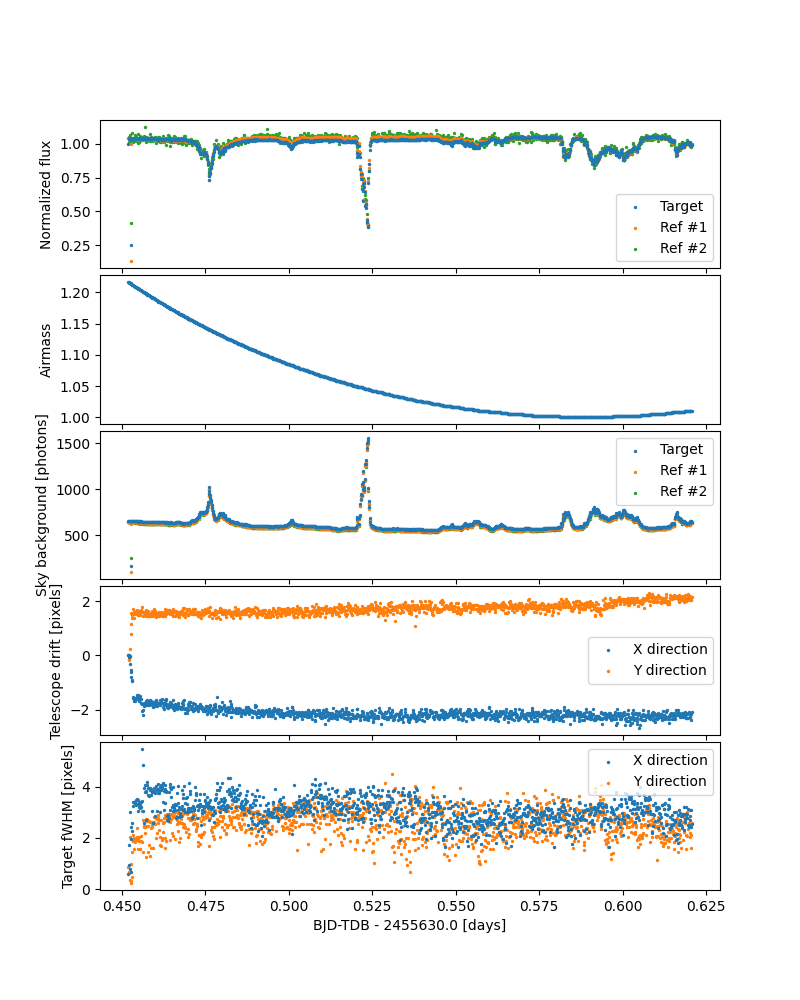

In [73]:
normalization_index = 1224
#time_offset = 2460024.0
time_offset = 2455630.0

#print(target_ap08.bjd_tdb)
#print(reference01_ap08.bjd_tdb)
#print(reference02_ap08.bjd_tdb)

print(target_ap08.aperture)
average_flux = np.mean(target_ap08.aperture)
closest_index = np.argmin(np.abs(target_ap08.aperture - average_flux))
print(closest_index)
#print(target_ap08.bjd_tdb-time_offset)
#print(type(target_ap08.bjd_tdb))
# print(reference01_ap08.bjd_tdb)
# print(len(target_ap08.bjd_tdb), len(target_ap08.aperture))

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(8,10))
# Reduce vertical space between axes
fig.subplots_adjust(hspace=0.05)

normalized_aperture = target_ap08.aperture / target_ap08.aperture[normalization_index]


axs[0].scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, target_ap08.aperture/target_ap08.aperture[normalization_index], s=2, zorder=3, c='C0', label='Target')
axs[0].scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, reference01_ap08.aperture/reference01_ap08.aperture[normalization_index], s=2, zorder=2, c='C1', label='Ref #1')
axs[0].scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, reference02_ap08.aperture/reference02_ap08.aperture[normalization_index], s=2, zorder=1, c='C2', label='Ref #2')
#axs[0].set_yticks(np.arange(0.90, 1.1, 0.025))
#axs[0].set_ylim(0.88, 1.052)
axs[0].set_ylabel('Normalized flux')
axs[0].legend()

axs[1].scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, target_ap08.airmass, s=2, c='C0', label='Airmass')
axs[1].set_ylabel('Airmass')

axs[2].scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, target_ap08.sky_background, s=2, zorder=3, c='C0', label='Target')
axs[2].scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, reference01_ap08.sky_background, s=2, zorder=2, c='C1', label='Ref #1')
axs[2].scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, reference02_ap08.sky_background, s=2, zorder=1, c='C2', label='Ref #2')
axs[2].set_ylabel('Sky background [photons]')
#axs[2].set_yscale('log')
axs[2].legend()

axs[3].scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, target_ap08.x_refined-target_ap08.x_refined[0], s=2, zorder=3, c='C0', label='X direction')
axs[3].scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, target_ap08.y_refined-target_ap08.y_refined[0], s=2, zorder=2, c='C1', label='Y direction')
axs[3].set_ylabel('Telescope drift [pixels]')
axs[3].legend()

axs[4].scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, target_ap08.x_fwhm, s=2, zorder=3, c='C0', label='X direction')
axs[4].scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, target_ap08.y_fwhm, s=2, zorder=2, c='C1', label='Y direction')
axs[4].set_ylabel('Target fWHM [pixels]')
axs[4].legend()


axs[4].set_xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.show()



#### Computing the differential photometry

**The target star's flux varies significantly at night due to atmospheric conditions, weather, the Moon's phase, and the telescope's viewing angle, all of which affect the number of photons hitting the CCD and thus the star's flux**
Focusing on the target star in the first panel shows that the absolute flux is highly variable during the night. You may have acknowledged that these variations can be seen due to changes in the atmospheric seeing, weather conditions, the Moon's phase and the telescope's angle (how much atmosphere it looks through). 
These will influence how many photons fall onto the pixels within a CCD and, consequently, the flux of the star

**Comparing the target star's flux with reference stars shows shared environmental effects. A planet's transit appears as a slight dip in the target's flux, which differential photometry helps isolate.**
Comparing the flux of the target star with the flux of the reference stars highlights how these effects simultaneously affect all the stars. The planet's transit in the target star is barely visible as a depression in the flux compared to the reference stars. We will deal with all these effects by performing differential photometry

**Comparison stars, in the same field as the target, experience similar environmental effects. By measuring them, we can correct the target's measurements, cancelling out instrumental effects.**
Comparison stars appear in the same field of view as your target object and, therefore, will be affected similarly by the factors discussed. So, by measuring comparison stars and your target object in each image, any variations of the comparison stars can be attributed to environmental factors/seeing effects and can be used to correct the measurements of your target object. In other words, the comparison stars are measured and used as a reference (hence reference stars) to cancel out the instrumental effects in the measurements of the target star.

**If conditions like seeing and weather affect star flux equally, we can correct this by dividing the target star's flux by the reference star's flux. For better accuracy, divide by the sum of stable reference stars' fluxes.**
If we assume that these effects (seeing variation, weather conditions, increase in background luminosity) affect the observed fluxes proportionally, e.g., an increase in cloud coverage causes a decrease in the flux of a factor that is the same for all the stars. We can remove these effects by dividing the flux of the target star by the flux of the reference star. To increase the precision of our correction, we can also divide the flux tìof the target star by the sum of the fluxes of the reference stars, including only those reference stars that do not show anomalous behaviour (e.g., strange variation in the absolute flux or sky background not observed in other stars)

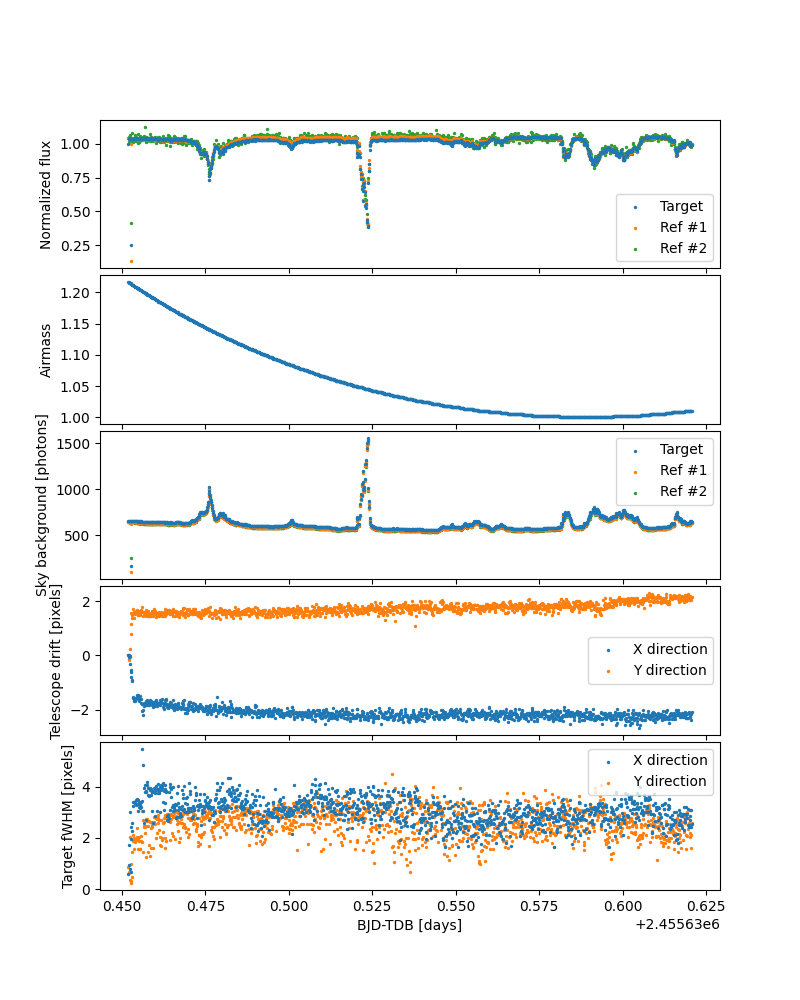

In [74]:
#normalization_index = 200
normalization_index = 1224
bjd_numeric = target_ap08.bjd_tdb.jd  # Преобразование объекта Time в числовой формат

fig, axs = plt.subplots(5, 1, sharex=True, figsize=(8,10))
# Reduce vertical space between axes
fig.subplots_adjust(hspace=0.05)

axs[0].scatter(bjd_numeric, target_ap08.aperture/target_ap08.aperture[normalization_index], s=2, zorder=3, c='C0', label='Target')
axs[0].scatter(bjd_numeric, reference01_ap08.aperture/reference01_ap08.aperture[normalization_index], s=2, zorder=2, c='C1', label='Ref #1')
axs[0].scatter(bjd_numeric, reference02_ap08.aperture/reference02_ap08.aperture[normalization_index], s=2, zorder=1, c='C2', label='Ref #2')
#axs[0].set_yticks(np.arange(0.90, 1.1, 0.025))
#axs[0].set_ylim(0.88, 1.052)
axs[0].set_ylabel('Normalized flux')
axs[0].legend()

axs[1].scatter(bjd_numeric, target_ap08.airmass, s=2, c='C0', label='Airmass')
axs[1].set_ylabel('Airmass')

axs[2].scatter(bjd_numeric, target_ap08.sky_background, s=2, zorder=3, c='C0', label='Target')
axs[2].scatter(bjd_numeric, reference01_ap08.sky_background, s=2, zorder=2, c='C1', label='Ref #1')
axs[2].scatter(bjd_numeric, reference02_ap08.sky_background, s=2, zorder=1, c='C2', label='Ref #2')
axs[2].set_ylabel('Sky background [photons]')
#axs[2].set_yscale('log')
axs[2].legend()

axs[3].scatter(bjd_numeric, target_ap08.x_refined-target_ap08.x_refined[0], s=2, zorder=3, c='C0', label='X direction')
axs[3].scatter(bjd_numeric, target_ap08.y_refined-target_ap08.y_refined[0], s=2, zorder=2, c='C1', label='Y direction')
axs[3].set_ylabel('Telescope drift [pixels]')
axs[3].legend()

axs[4].scatter(bjd_numeric, target_ap08.x_fwhm, s=2, zorder=3, c='C0', label='X direction')
axs[4].scatter(bjd_numeric, target_ap08.y_fwhm, s=2, zorder=2, c='C1', label='Y direction')
axs[4].set_ylabel('Target fWHM [pixels]')
axs[4].legend()
axs[4].set_xlabel('BJD-TDB [days]')
plt.show()

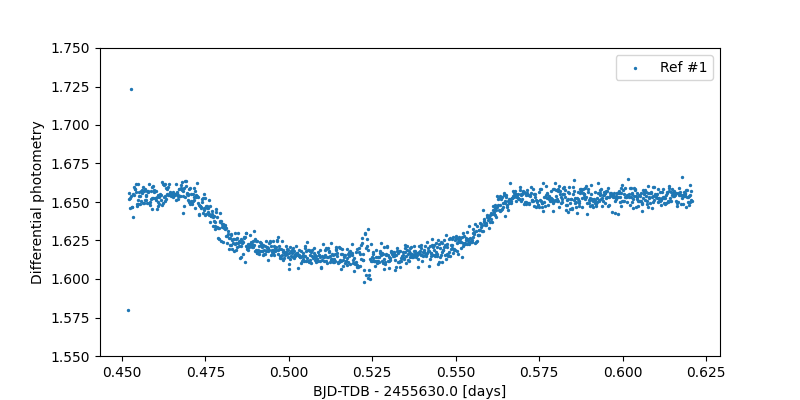

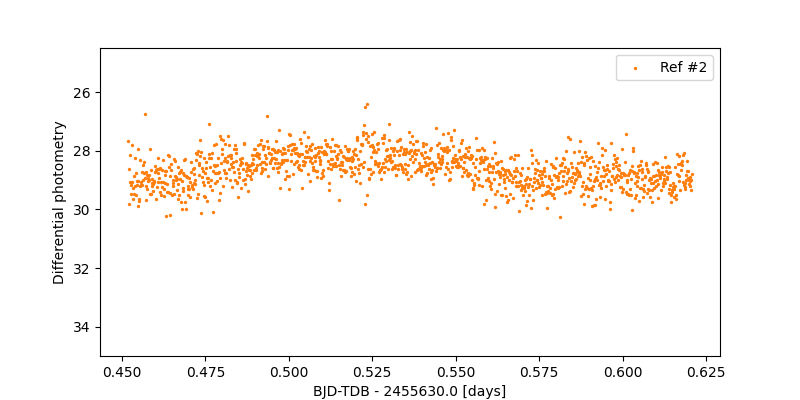

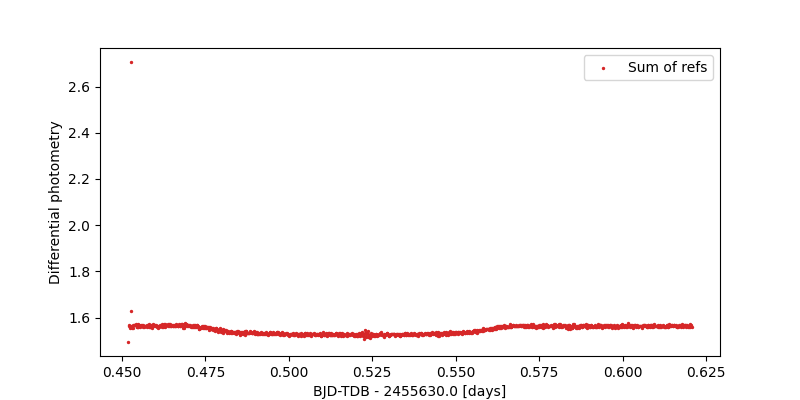

In [79]:
plt.figure(figsize=(8,4))
plt.scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, target_ap08.aperture/reference01_ap08.aperture, s=2, c='C0', label='Ref #1')
plt.xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.ylabel('Differential photometry')
plt.ylim(1.550, 1.750)
plt.legend()
plt.show()


plt.figure(figsize=(8,4))
plt.scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, target_ap08.aperture/reference02_ap08.aperture, s=2, c='C1', label='Ref #2')
plt.xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.ylabel('Differential photometry')
plt.ylim(35.000, 24.500)
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, target_ap08.aperture/(reference01_ap08.aperture+reference02_ap08.aperture), s=2, c='C3', label='Sum of refs')
plt.xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.ylabel('Differential photometry')
#plt.ylim(0.620, 0.700)
plt.legend()
plt.show()

#### Selection of the best differential photometry
The plot above shows the three differential photometry using the two reference stars and the sum of the flux of the two reference stars selected in this example. With the increasing flux of the reference star, the differential photometry will assume smaller values, so the plot as it is now is not highly informative, as it gives the deceiving idea that the differential photometry obtained with the fainter star (the second reference star) is the best one in highlighting the transit of the planet.

*На графике показаны три дифференциальные фотометрии с двумя опорными звездами и их суммой. При увеличении потока опорной звезды значения дифференциальной фотометрии уменьшаются, что может ввести в заблуждение, будто использование более слабой второй опорной звезды лучше показывает транзит планеты.*

We need to find a quantitative criterion to select the best differential photometry. How do we define the best differential photometry? Generally speaking, the answer relies on the physical phenomenon we want to study. In our specific case, we are interested in modelling the transit of the planet, and we know that in the short time around the observations, the flux of the star can be considered constant, so the measurements obtained before and after the transit provide an excellent opportunity to identify the differential photometry approach delivering the best results. As we expect a constant value of the differential photometry outside the transit, the standard deviation of this portion of the light curve can provide a quantitative criterion for selecting the best photometric extraction.

*Нам нужно определить количественный критерий для выбора лучшей дифференциальной фотометрии. В нашем случае это связано с моделированием транзита планеты. Поток звезды считается постоянным до и после транзита, поэтому стандартное отклонение в этих периодах поможет выбрать лучший метод фотометрии.*

First, we manually select the interval of exclusion for the transit. We do not need to pinpoint precisely the beginning and end of the transit; we can be more relaxed and exclude some observations before and after the transit. What is really important is to always use the same selection (the same epochs) to compute the standard deviation across different combinations of reference stars and aperture selections.

*Сначала мы вручную выбираем интервал для исключения данных во время транзита, не стремясь точно определить его начало и конец. Главное — всегда использовать одинаковый интервал для расчёта стандартного отклонения при различных комбинациях опорных звезд и апертур.*

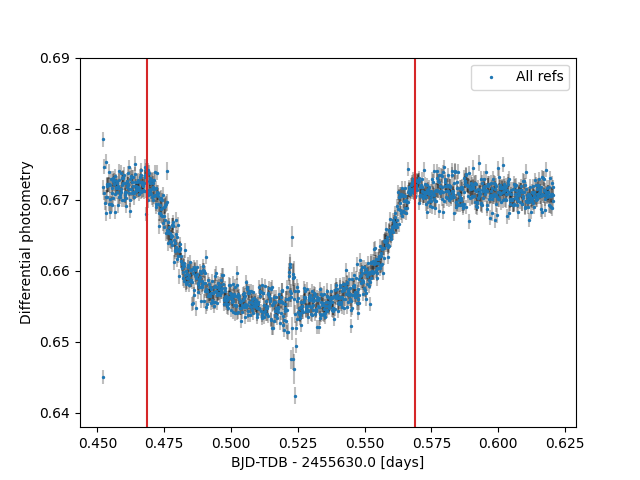

[838342.99041248 876946.4037722  872004.90376084 ... 829817.44472618
 835193.60442501 834919.03923461]
[530602.51905583 529696.03053682 527767.12694728 ... 500685.10409889
 505685.59521864 505831.3966774 ]
[768940.20326726 762819.38217895 770312.43796112 ... 736721.14818909
 737624.84500291 740618.47524877]


In [58]:
differential_ap08_ref01 = target_ap08.aperture/reference01_ap08.aperture
differential_ap08_ref02 = target_ap08.aperture/reference02_ap08.aperture
# differential_ap08_ref01 и differential_ap08_ref02 вычисляют отношение 
# потока целевой звезды к потоку каждой из двух референтных звезд отдельно. 
# Это помогает устранить внешние переменные, влияющие на яркость, такие как 
# атмосферные изменения, поскольку обе звезды должны быть подвержены тому же 
# атмосферному воздействию.

# Errors in ratio = ratio * sqrt( (err_target/target)^2 + (err_ref/ref)^2 )
#differential_ap08_ref01_error = ####  You must compute the error by yourself
#differential_ap08_ref02_error = ####  You must compute the error by yourself
#differential_ap08_allref_error = ####  You must compute the error by yourself

# Errors in ratio = ratio * sqrt( (err_target/target)^2 + (err_ref/ref)^2 )
differential_ap08_ref01_error = differential_ap08_ref01 * np.sqrt(
    (target_ap08.aperture_errors/target_ap08.aperture)**2 +
    (reference01_ap08.aperture_errors/reference01_ap08.aperture)**2
)
differential_ap08_ref02_error = differential_ap08_ref02 * np.sqrt(
    (target_ap08.aperture_errors/target_ap08.aperture)**2 +
    (reference02_ap08.aperture_errors/reference02_ap08.aperture)**2
)

#  Sum of references:
sum_aperture = reference01_ap08.aperture + reference02_ap08.aperture
sum_refs_err = np.sqrt(reference01_ap08.aperture_errors**2 + reference02_ap08.aperture_errors**2)

differential_ap08_allref = target_ap08.aperture / sum_aperture

differential_ap08_allref_error = differential_ap08_allref * np.sqrt(
    (target_ap08.aperture_errors/target_ap08.aperture)**2 +
    (sum_refs_err/sum_aperture)**2
)
# differential_ap08_allref вычисляет отношение потока целевой звезды к сумме потоков двух 
# референтных звезд. Это может повысить точность, сгладив индивидуальные колебания референтных звезд.


plt.figure()
plt.scatter(target_ap08.bjd_tdb.to_value('jd')-time_offset, differential_ap08_allref, s=2, label='All refs')
plt.errorbar(target_ap08.bjd_tdb.to_value('jd')-time_offset, differential_ap08_allref, yerr=differential_ap08_allref_error, fmt=' ', c='k', alpha=0.25, zorder=-1) 
plt.legend()
plt.axvline(2455630.4686-time_offset, c='C3')
plt.axvline(2455630.5689-time_offset, c='C3')
plt.xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.ylabel('Differential photometry')
plt.ylim(0.638, 0.690)
plt.show()

print(target_ap08.aperture)
print(reference01_ap08.aperture)
print(reference02_ap08.aperture)


However, a direct comparison of the standard deviation of the differential photometry computed outside the transit is not possible, as the absolute value depends on the ratio between the brightness of the target and reference star(s).

To better understand this point, let's do an example. Imagine two cases where the average values of the differential photometry are $\text{df}_1 = 0.8 \pm 0.2$ and $\text{df}_2 = 2.0 \pm 0.4$, respectively. The absolute value of the standard deviation is smaller in the first case. However, the corresponding relative errors are:

$$
\epsilon_{\text{df}_1} = \frac{\sigma_{\text{df}_1}}{\text{df}_1} = 0.25, \quad \epsilon_{\text{df}_2} = 0.20
$$



i.e., the relative error of the second differential photometry is smaller. To properly compare the two differential photometry, we must first normalize each of them by their average values so that the `numpy.std` function will provide an estimate of the **relative error** associated with the light curve.

I use a polynomial trend in the following example to normalize the light curve. A linear or quadratic polynomial may be sufficient if eye inspection reveals the presence of a trend. A trend may appear if the target and reference stars have different spectral types, as the atmospheric extinction strongly depends on the wavelength.

Finally, the standard deviation is computed on the normalized light curve.

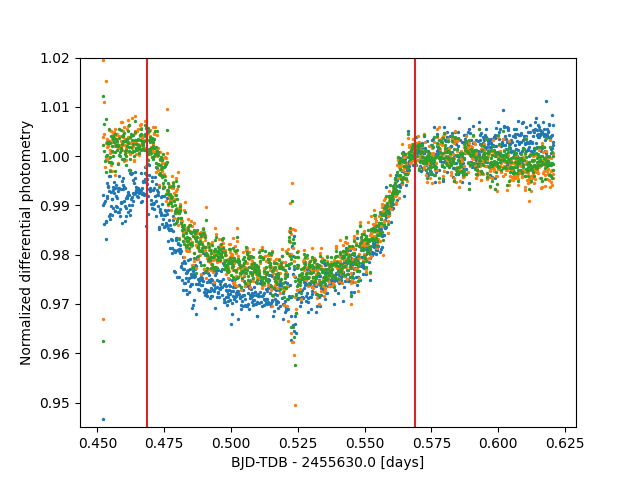

Standard deviation aperture 08 reference #1:    0.0557746
Standard deviation aperture 08 reference #2:    0.0392647
Standard deviation aperture 08 all references : 0.0258714


In [63]:
##########################################################################
# E) Fit a polynomial trend and normalize
##########################################################################
# out-of-transit region: for example, exclude from 2460024.3450 -> 2460024.4350
bjd_tdb = target_ap08.bjd_tdb.value
bjd_median = np.median(bjd_tdb)

# https://numpy.org/doc/stable/reference/routines.polynomials.package.html#module-numpy.polynomial
from numpy.polynomial import Polynomial
out_transit_selection = (target_ap08.bjd_tdb.value < 2455630.4686) | (target_ap08.bjd_tdb.value > 2455630.5689)
out_transit_selection = ((target_ap08.bjd_tdb.value < 2455630.4686) | (target_ap08.bjd_tdb.value > 2455630.5689)) & (target_ap08.bjd_tdb.value < 2455630.5895)

poly_ap08_ref01_deg01_pfit = Polynomial.fit(bjd_tdb[out_transit_selection] - bjd_median, differential_ap08_ref01[out_transit_selection], deg=1)
poly_ap08_ref02_deg01_pfit = Polynomial.fit(bjd_tdb[out_transit_selection] - bjd_median, differential_ap08_ref02[out_transit_selection], deg=1)
poly_ap08_allref_deg01_pfit = Polynomial.fit(bjd_tdb[out_transit_selection] - bjd_median, differential_ap08_allref[out_transit_selection], deg=1)
differential_ap08_ref01_normalized = differential_ap08_ref01 / poly_ap08_ref01_deg01_pfit(bjd_tdb - bjd_median)
differential_ap08_ref02_normalized = differential_ap08_ref02 / poly_ap08_ref02_deg01_pfit(bjd_tdb - bjd_median)
differential_ap08_allref_normalized = differential_ap08_allref / poly_ap08_allref_deg01_pfit(bjd_tdb - bjd_median)

# Propagate errors for normalized curve:
#   (target/reference)/fitted_trend -> total factor is 1 / fitted_trend
#   so error ~ sqrt( (diff_err/fitted_trend)^2 + (diff * trend_err / trend^2 )^2 ) ...
#   but we have not derived a formal error on the polynomial.
# Here we just do the simplest approach ignoring polynomial fit error:
differential_ap08_ref01_normalized_error = differential_ap08_ref01_error / differential_ap08_ref01_normalized
differential_ap08_ref02_normalized_error = differential_ap08_ref02_error / differential_ap08_ref02_normalized
differential_ap08_allref_normalized_error = differential_ap08_allref_error / differential_ap08_allref_normalized
##differential_ap08_ref01_normalized_error = ####
##differential_ap08_ref02_normalized_error = ####
##differential_ap08_allref_normalized_error = ####

plt.figure()
plt.scatter(bjd_tdb - time_offset, differential_ap08_ref01_normalized, s=2)
plt.scatter(bjd_tdb - time_offset, differential_ap08_ref02_normalized, s=2)
plt.scatter(bjd_tdb - time_offset, differential_ap08_allref_normalized, s=2)
plt.axvline(2455630.4686 - time_offset, c='C3')
plt.axvline(2455630.5689 - time_offset, c='C3')
plt.ylim(0.945, 1.020)
plt.xlabel('BJD-TDB - {0:.1f} [days]'.format(time_offset))
plt.ylabel('Normalized differential photometry')
plt.show()
print('Standard deviation aperture 08 reference #1:    {0:.7f}'.format(np.std(differential_ap08_ref01_normalized[out_transit_selection])))
print('Standard deviation aperture 08 reference #2:    {0:.7f}'.format(np.std(differential_ap08_ref02_normalized[out_transit_selection])))
print('Standard deviation aperture 08 all references : {0:.7f}'.format(np.std(differential_ap08_allref_normalized[out_transit_selection])))

##### Using different photometric parameters

Using the AperturePhotometry class is highly convenient for exploring the effects of different photometric parameters. 

Below, I report an example using the same reference stars but with a different aperture radius

In [65]:
##########################################################################
# F) Save some results via pickle
##########################################################################
# Example: saving the BJD, the ratio with errors, etc

pickle.dump(bjd_tdb, open(f'taste_bjdtdb.p', 'wb'))

# Save the raw ratio
pickle.dump(differential_ap08_allref,         open(f'differential_allref.p','wb'))
pickle.dump(differential_ap08_allref_error,     open(f'differential_allref_error.p','wb'))

# Save the normalized ratio
pickle.dump(differential_ap08_allref_normalized,    open(f'differential_allref_normalized.p','wb'))
pickle.dump(differential_ap08_allref_normalized_error,open(f'differential_allref_normalized_error.p','wb'))

print("Done. Data saved to pickle files.")


Done. Data saved to pickle files.


In [ ]:
from aperture_class import AprturePhotometry

time_start = time()

target_ap08 = AprturePhotometry()

target_ap08.provide_aperture_parameters(inner_radius, 
                                        outer_radius, 
                                        aperture, 
                                        x_target, 
                                        y_target)
target_ap08.aperture_photometry()


time_end = time()

print("Elapsed time", time_start-time_end)


In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(target_ap08.bjd_tdb, target_ap08.aperture, s=2)
plt.scatter(reference_02_ap08.bjd_tdb, reference_02_ap08.aperture, s=2)


In [ ]:
time_offset = 24600024.00
normalization_index = 200 # ?

fig, axs = plt.subplots(5,1, sharex=True, figsize=(8,10))
fig.subplots_adjust(hspace=0.05)

axs[0].scatter(target_ap08.bjd_tdb-time_offset, 
               target_ap08.aperture / target_ap08.aperture[normalization_index],
               s=2,
               zorder=3,
               c='C0',
               label='Target')

axs[0].scatter(reference01_ap08.bjd_tdb-time_offset, 
               reference01_ap08.aperture / reference01_ap08.aperture[normalization_index],
               s=2,
               zorder=3,
               c='C0',
               label='Target')

axs[0].scatter(reference02_ap08.bjd_tdb-time_offset, 
               reference02_ap08.aperture / reference02_ap08.aperture[normalization_index],
               s=2,
               zorder=3,
               c='C0',
               label='Target')
axs[0].set_label('Normalized flux')
axs[0].legend()

axs[1].scatter(target_ap08.bjd_tdb, target_ap08.airmass, s=2, c='C0', label='Airmass')
axs[1].set_ylabel('Airmass')

axs[2].scatter(target_ap08.bjd_tdb - time_offset, target_ap08.skybackground, 
               s=2, zorder=3, c='C0', label='Target')

axs[2].scatter(reference01_ap08.bjd_tdb - time_offset, reference01_ap08.skybackground, 
               s=2, zorder=3, c='C1', label='Target')

axs[2].scatter(reference02_ap08.bjd_tdb - time_offset, reference02_ap08.skybackground, 
               s=2, zorder=3, c='C2', label='Target')


axs[4].scatter(target_ap08.bjd_tdb - time_offset, 
               target_ap08.x_refined - target_ap08.x_refined[normalization_index],
                s=2, zorder=3, c='C0', label='X FWHM')

axs[4].scatter(target_ap08.bjd_tdb - time_offset, 
               target_ap08.y_refined - target_ap08.y_refined[normalization_index],
                s=2, zorder=2, c='C1', label='Y FWHM')

axs[4].set_ylabel('Telescope drift [pixel]')
axs[4].legend()
axs[4].set_label("Bjd-tdb ....чот там ")

plt.show()


In [ ]:
plt.figure()
plt.scatter(target_ap08.bjd_tdb - time_offset, target_ap08.aperture/reference_01_ap08.aperture,
            s=2,
            label='Ref #1')
plt.scatter(target_ap08.bjd_tdb - time_offset, target_ap08.aperture/reference_02_ap08.aperture,
            s=2,
            label='Ref #2')

plt.scatter(target_ap08.bjd_tdb - time_offset,
            target_ap08.aperture/ (reference_01_ap08.aperture + reference_02_ap08.aperture),
            s=2,
            label='All refs')

In [ ]:
differential_ap08_ref01 = target_ap08.aperture/reference_01_ap08.aperture
differential_ap08_ref02 = target_ap08.aperture/reference_02_ap08.aperture
differential_ap08_allref = target_ap08.aperture/(reference_02_ap08.aperture + reference_02_ap08.aperture)

median_bjdtdb = np.median(target_ap08.bjd_tdb)

time_01 = time_offset + 0.340 # это значение взято из графика!

time_02 = time_offset + 0.430 # это значение взято из графика!

out_transit_selection = (target_ap08.bjd_tdb < time_01) | (target_ap08.bjd_tdb > time_02)

out_transit_selection = (
    (target_ap08.bjd_tdb < time_01) | (target_ap08.bjd_tdb > time_02
     ) & (target_ap08.bjd_tdb < time_offset + 0.450))

